# Телеком

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

Оператор предоставляет два основных типа услуг: 
1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:
- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).
За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

***Цель проекта***

- Построить модель для прогнозирования оттока клиентов с предельно большим значением ROC-AUC (>=0.85), дополнительно посчитать и интерпретировать метрику Accuracy

***Задачи проекта***

- Загрузить данные;
- Посмотреть общую информацию о данных;
- Проверить данные на наличие пропусков и дубликатов;
- Сделать предобработку данных;
- Исследовать корреляционные зависимости;
- Проверить сбалансированность данных;
- Выполнить отбор признаков и провести их распределение;
- Построить модели и оценить их на кросс-валидации;
- Выбрать лучшую модель для тестирования;
- Провести анализ важности признаков;
- Подготовить отчет для заказчика.

## Анализ данных

### Импортируем библиотеки и модули

In [1]:
pip install plot-utils

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install -q phik

In [3]:
!pip install catboost

In [4]:
pip install -U scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import numpy as np

import lightgbm as lgb
import matplotlib.pyplot as plt
import phik
import plot_utils as pu
import random
import seaborn as sns
import sys
import warnings

from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from phik import resources, report
from phik.report import plot_correlation_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import *

from sklearn.feature_selection import RFE

from sklearn.pipeline import Pipeline

plt.rcParams["figure.figsize"] = (12,5)


### Отключим некритические предупреждения в коде

In [6]:
warnings.filterwarnings("ignore")

### Откроем файлы с данными

In [7]:
import os

try:
    contract = pd.read_csv('contract_new.csv')
except FileNotFoundError:
    contract = pd.read_csv('/datasets/contract_new.csv')

try:
    personal = pd.read_csv('personal_new.csv')
except FileNotFoundError:
    personal = pd.read_csv('/datasets/personal_new.csv')
    
try:
    internet = pd.read_csv('internet_new.csv')
except FileNotFoundError:
    internet = pd.read_csv('/datasets/internet_new.csv')
    
try:
    phone = pd.read_csv('phone_new.csv')
except FileNotFoundError:
    phone = pd.read_csv('/datasets/phone_new.csv')

### Выведем общую информацию о датасетах

In [8]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [9]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [10]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [11]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


### Выведем первые 5 строк данных на экран

In [12]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [13]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [14]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [15]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


### Переименуем названия столбцов в соотвествии с хорошим стилем

In [16]:
contract.columns = contract.columns.str.lower()
contract = contract.rename(columns={'customerid': 'customer_id', 'begindate':'begin_date', 'enddate':'end_date',
                                    'paperlessbilling':'paperless_billing', 'paymentmethod':'payment_method',
                                    'monthlycharges':'monthly_charges', 'totalcharges':'total_charges'})
contract.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')

In [17]:
personal.columns = personal.columns.str.lower()
personal = personal.rename(columns={'customerid': 'customer_id', 'seniorcitizen':'senior_citizen'})
personal.columns

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')

In [18]:
internet.columns = internet.columns.str.lower()
internet = internet.rename(columns={'customerid': 'customer_id', 'internetservice':'internet_service',
                                    'onlinesecurity':'online_security', 'onlinebackup':'online_backup',
                                    'deviceprotection':'device_protection', 'techsupport':'tech_support',
                                    'streamingtv':'streaming_tv', 'streamingmovies':'streaming_movies'})
internet.columns

Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')

In [19]:
phone.columns = phone.columns.str.lower()
phone = phone.rename(columns={'customerid': 'customer_id', 'multiplelines':'multiple_lines'})
phone.columns

Index(['customer_id', 'multiple_lines'], dtype='object')

### Проверим датасеты на наличие явных дубликатов

In [20]:
contract.duplicated().sum()

0

In [21]:
personal.duplicated().sum()

0

In [22]:
internet.duplicated().sum()

0

In [23]:
phone.duplicated().sum()

0

### Проверим датасеты на наличие пропусков

In [24]:
contract.isna().sum()

customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
dtype: int64

In [25]:
personal.isna().sum()

customer_id       0
gender            0
senior_citizen    0
partner           0
dependents        0
dtype: int64

In [26]:
internet.isna().sum()

customer_id          0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
dtype: int64

In [27]:
phone.isna().sum()

customer_id       0
multiple_lines    0
dtype: int64

Итого, согласно документации у нас 4 датасета:
- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Датасет 'contract_new' содержит данные:
- customer_id - идентификатор клиента;
- begin_date - дата начала договора;
- end_date - дата окончания договора;
- type - тип договора;
- paperless_billing - выставлен счет или нет;
- payment_method - способ оплаты;
- monthly_charges - сумма ежемесячного платежа;
- total_charges - общая сумма начислений.

Датасет 'personal_new' содержит данные:
- customer_id - идентификатор клиента;
- gender - пол клиента;
- senior_citizen - есть ли статус пенсионера;
- partner - есть ли партнер у клиента;
- dependents - есть ли иждивенцы у клиента.

Датасет 'internet_new' содержит данные:
- customer_id - идентификатор клиента;
- internet_service - наименование интернет услуги;
- online_security  - подключена ли онлайн безопасность;
- online_backup - есть ли онлайн резервное копирование;
- device_protection - подключена ли защита устройства;
- tech_support - есть ли подключение технической поддержки;
- streaming_tv - подключена ли телевизионная трансляция;
- streaming_movies - есть ли подключение на трансляцию фильмов.

Датасет 'phone_new' содержит данные:
- customer_id - идентификатор клиента;
- multiple_lines - подключено несколько линий или нет.

***Вывод***

- Вывели общую информацию о датасетах;
- Переименовали столбцы в соответствии с хорошим стилем;
- Дубликаты и пропуски отсутствуют.

***План работ***

- Объединить данные в общий датасет;
- Обработать пропуски и дубликаты;
- Закодируем категориальные переменные (1 или 0);
- Посмотрим на корреляцию признаков в объедененном датасете при помощи матрицы корреляции и графиков;
- Убираем дисбаланс классов;
- Создаем целевой признак - клиент уйдет/останется;
- Удалим неинформативные столбцы;
- Подготавливаем итоговую 'очищенную' таблицу с данными;
- Проводим анализ распределения признаков;
- Делим данные на 2 выборки;
- Выбираем модели для исследования данных и подбираем гипперпараметры;
- Модель с лучшим показателем ROC-AUC и проверяем ее на тестовой выборке;
- Проводим анализ матрицы ошибок;
- Проводим анализ важности признаков;
- Рефлексия.

## Исследовательский анализ данных

### Объединим данные в один датасет

In [28]:
telecom = pd.merge(contract, personal, how='left', on='customer_id').merge(internet, how='left', on='customer_id').merge(phone, how='left', on='customer_id')

### Выведем общую информацию об объединенном датасете

In [29]:
telecom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  internet_service   5517 non-null   object 
 13  online_security    5517 non-null   object 
 14  online_backup      5517 non-null   object 
 15  device_protection  5517 non-null   object 
 16  tech_support       5517 

### Выведем первые 5 строк полученного датасета на экран

In [30]:
telecom.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


### Посмотрим на размер полученных данных

In [31]:
telecom.shape

(7043, 20)

### Обработка пропусков в общем датасете

In [32]:
telecom.isna().sum()

customer_id             0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
dtype: int64

Таким образом, можно предположить, что пропуски появились из-за отсутствия у клиентов данного вида услуг, поэтому заменим все пропуски на 'No'.

In [33]:
telecom = telecom.fillna('No')

In [34]:
telecom.isna().sum()

customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
gender               0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
multiple_lines       0
dtype: int64

### Посмотрим на количество явных дубликатов в общем датасете

In [35]:
telecom.duplicated().sum()

0

### Закодируем категориальные переменные

Если в столбце 'end_date' указано 'No', значит клиент является действующим. По значению в этой колонке создадим условие, для заполнения столбца об оттоке клиента. '0' - действующий клиент, '1' - клиент, прекративший сотрудничество.

In [36]:
telecom['result_churn'] = np.where(telecom['end_date']=='No', '0', '1')

### Изменим тип данных в столбцах 'begin_date', 'end_date', 'total_charges' и 'senior_citizen'

In [37]:
telecom['begin_date'] = pd.to_datetime(telecom['begin_date'])
telecom['senior_citizen'] = telecom['senior_citizen'].astype(object)

In [38]:
telecom['total_charges'] = pd.to_numeric(telecom['total_charges'], errors='coerce')

Если в стобце 'end_date' не указана дата, значит на 01.02.2020 клиент являлся действующим.

In [39]:
telecom.loc[telecom['end_date'] == 'No', 'end_date'] = pd.to_datetime('2020-02-01')
telecom['end_date'] = pd.to_datetime(telecom['end_date'])

### Создадим столбец 'total_time'

Он нам нужен для видимости длительности периода существования клиента.

In [40]:
telecom['total_time']=(telecom['end_date']-telecom['begin_date']).dt.days

In [41]:
telecom.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,result_churn,total_time
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,DSL,No,Yes,No,No,No,No,No,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,...,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,DSL,Yes,Yes,No,No,No,No,No,0,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,...,DSL,Yes,No,Yes,Yes,No,No,No,0,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,...,Fiber optic,No,No,No,No,No,No,No,0,153


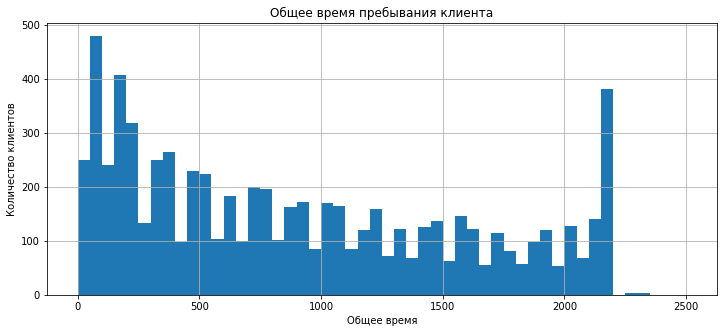

In [42]:
telecom['total_time'].hist(bins=50, range = (0,2500))
plt.title('Общее время пребывания клиента')
plt.xlabel('Общее время')
plt.ylabel('Количество клиентов')
plt.show()

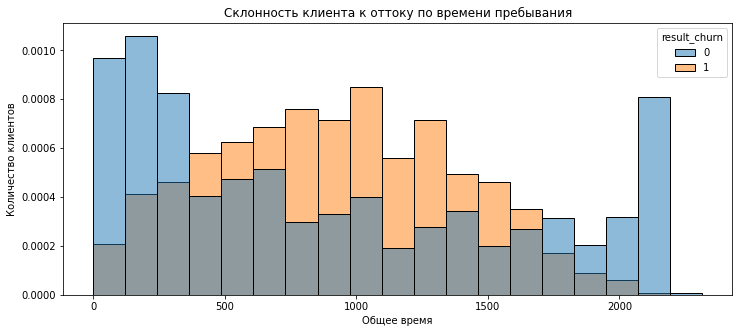

In [43]:
sns.histplot(data=telecom, x='total_time', hue='result_churn', stat='density', common_norm=False)
plt.xlabel('Общее время')
plt.ylabel('Количество клиентов')
plt.title('Склонность клиента к оттоку по времени пребывания');

Из графиков видно, что максимальное число людей являлись клиентами менее года. Наблюдается отток клиентов примерно после 1,5 лет пользования услугами компании. Так же видно, что большое количество клиентов пользовались услугами на протяжении 6 лет. Самые склонные к оттоку клиенты по общему времени пребывания от 1 года до 4,5 лет.

In [44]:
telecom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   object        
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   7043 non-null   object        
 13  online_security    7043 non-null   object        
 14  online_b

### Посмотрим на значения в столбце 'total_charges'

In [45]:
telecom['total_charges'].describe()

count    7032.000000
mean     2118.621822
std      2112.736199
min        19.050000
25%       439.745000
50%      1345.275000
75%      3239.317500
max      9221.380000
Name: total_charges, dtype: float64

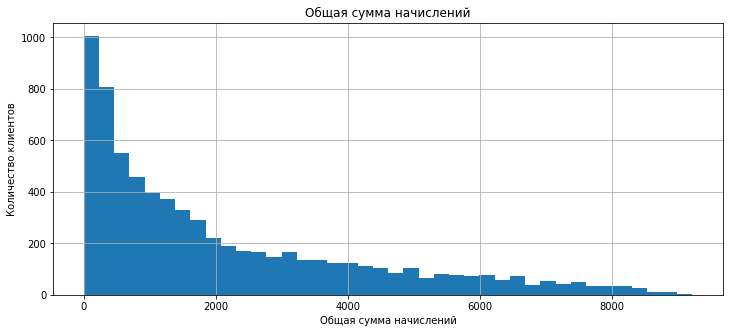

In [46]:
telecom['total_charges'].hist(bins=40, range = (0,9222))
plt.title('Общая сумма начислений')
plt.xlabel('Общая сумма начислений')
plt.ylabel('Количество клиентов')
plt.show()

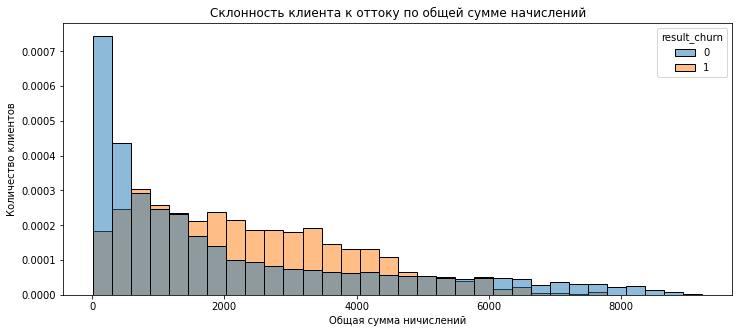

In [47]:
sns.histplot(data=telecom, x='total_charges', hue='result_churn', stat='density', common_norm=False)
plt.xlabel('Общая сумма ничислений')
plt.ylabel('Количество клиентов')
plt.title('Склонность клиента к оттоку по общей сумме начислений');

Максимальная сумма общих начислений составляет более 9000 рублей. Наблюдается склонные к оттоку клиенты с общей суммой начислений от 1400 рублей до 4900 рублей.

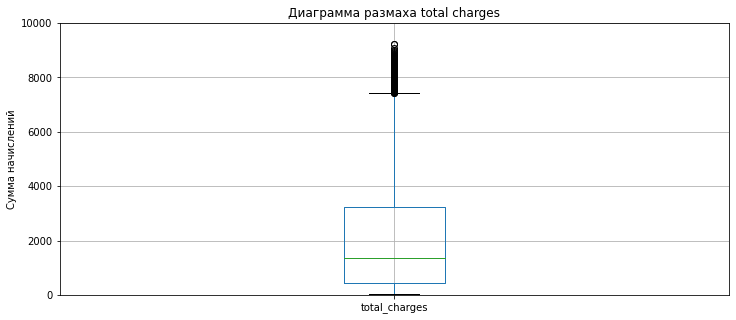

In [48]:
telecom.boxplot(column='total_charges')
plt.ylim(0, 10000)
plt.title('Диаграмма размаха total charges')
plt.ylabel('Сумма начислений')
plt.show()

Есть выбросы со общей суммой начислений около 8000 и выше. Удалим выбросы из столбца 'total_charges' квантильным методом.

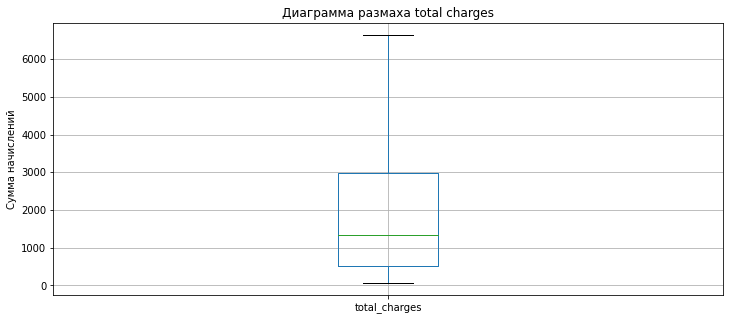

In [49]:
Q1 =  telecom['total_charges'].quantile(0.05)
Q3 = telecom['total_charges'].quantile(0.95)
IQR = Q3 - Q1
telecom_final = telecom[(telecom['total_charges'] > Q1) & (telecom['total_charges'] < Q3)]
telecom_final.boxplot(column='total_charges')
plt.title('Диаграмма размаха total charges')
plt.ylabel('Сумма начислений');

In [50]:
telecom_final['total_charges'].describe()

count    6328.000000
mean     1929.717887
std      1731.679340
min        77.840000
25%       507.175000
50%      1345.275000
75%      2995.750000
max      6630.830000
Name: total_charges, dtype: float64

### Посмотрим на данные в столбце 'type'

In [51]:
telecom_final['type'].value_counts()

Month-to-month    3519
Two year          1444
One year          1365
Name: type, dtype: int64

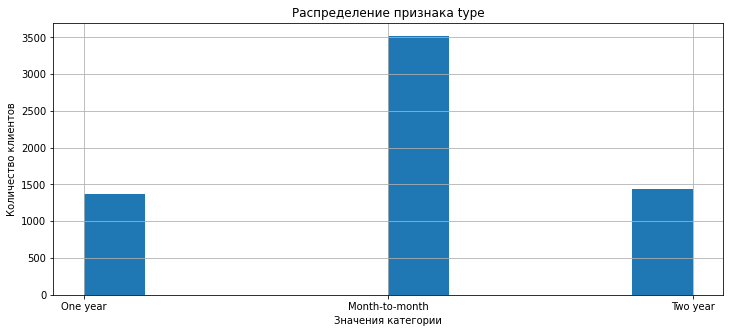

In [52]:
telecom_final['type'].hist()
plt.title('Распределение признака type')
plt.xlabel('Значения категории')
plt.ylabel('Количество клиентов');

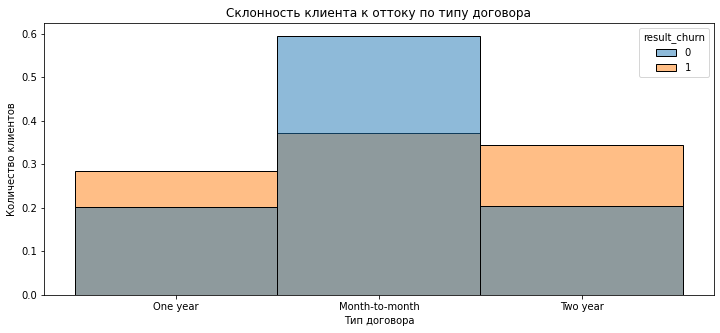

In [53]:
sns.histplot(data=telecom_final, x='type', hue='result_churn', stat='density', common_norm=False)
plt.xlabel('Тип договора')
plt.ylabel('Количество клиентов')
plt.title('Склонность клиента к оттоку по типу договора');

Существует три типа договоров: ежемесячный, годовой и двухлетний. Преобладает помесячный тип договора. Скорее всего, это связано с тем, что большинство людей не любит загадывать далеко вперед и если подвернутся более лучшие условия, то перейдут к другому поставщику для оказания услуг. Самое большое количество клиентов, склонных к оттоку с двухлетним типом договора.

### Посмотрим на данные в столбце 'paperless_billing'

In [54]:
telecom_final['paperless_billing'].value_counts()

Yes    3773
No     2555
Name: paperless_billing, dtype: int64

Выставленных счетов практически в 2 раза больше.

### Посмотрим на данные в столбце 'payment_method'

In [55]:
telecom_final['payment_method'].value_counts()

Electronic check             2196
Bank transfer (automatic)    1392
Credit card (automatic)      1371
Mailed check                 1369
Name: payment_method, dtype: int64

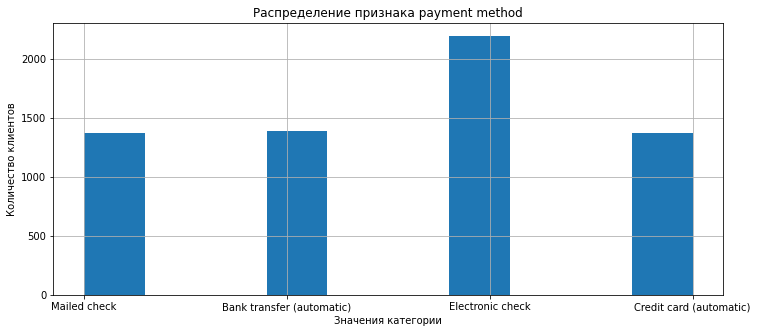

In [56]:
telecom_final['payment_method'].hist()
plt.title('Распределение признака payment method')
plt.xlabel('Значения категории')
plt.ylabel('Количество клиентов');

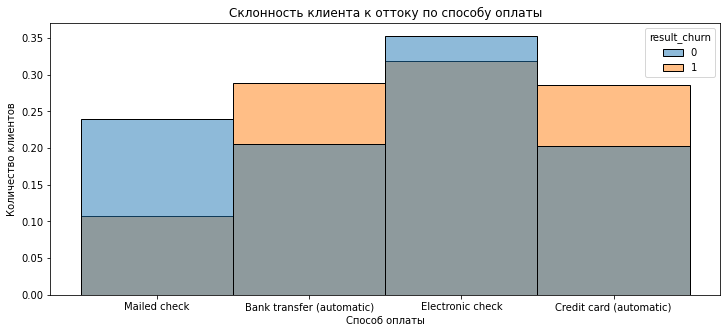

In [57]:
sns.histplot(data=telecom_final, x='payment_method', hue='result_churn', stat='density', common_norm=False)
plt.xlabel('Способ оплаты')
plt.ylabel('Количество клиентов')
plt.title('Склонность клиента к оттоку по способу оплаты');

Существует 4 способа оплаты услуг: электронный чек, банковский перевод (автоматический), списание с кредитной карты (автоматическое) и отправленный по почте чек. Преобладает способ - электронный чек, остальные распределены примерно одинаково. Наиболее склонны к оттоку клиенты с оплатой при помощи автоматического банковского перевода и автоматического списания с кредитной карты.

### Посмотрим на данные в столбце 'gender'

In [58]:
telecom_final['gender'].value_counts()

Male      3185
Female    3143
Name: gender, dtype: int64

По клиентам распределение мужчин и женщин практически одинаковое.

### Посмотрим на данные в столбце 'senior_citizen'

In [59]:
telecom_final['senior_citizen'].value_counts()

0    5280
1    1048
Name: senior_citizen, dtype: int64

Клиентов-пенсионеров значительно меньше, чем остальных пользователей услуг.

### Посмотрим на данные в столбце 'partner'

In [60]:
telecom_final['partner'].value_counts()

No     3268
Yes    3060
Name: partner, dtype: int64

Женатых/замужних и свободных практически одинаковое количество.

### Посмотрим на данные в столбце 'dependents'

In [61]:
telecom_final['dependents'].value_counts()

No     4426
Yes    1902
Name: dependents, dtype: int64

Без иждивенцев клиентов практически в 2 раза больше, чем с иждивенцами.

Переходим к анализу данных по оказываемым услугам.

### Посмотрим на данные в столбце 'internet_service'

In [62]:
telecom_final['internet_service'].value_counts()

Fiber optic    2748
DSL            2284
No             1296
Name: internet_service, dtype: int64

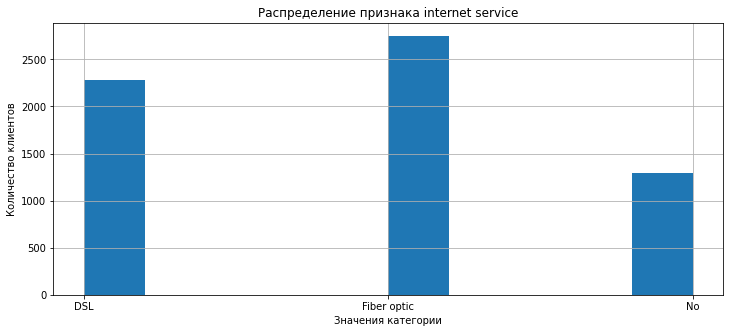

In [63]:
telecom_final['internet_service'].hist()
plt.title('Распределение признака internet service')
plt.xlabel('Значения категории')
plt.ylabel('Количество клиентов');

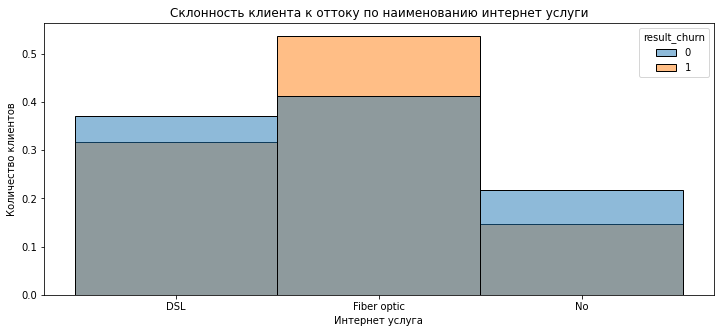

In [64]:
sns.histplot(data=telecom_final, x='internet_service', hue='result_churn', stat='density', common_norm=False)
plt.xlabel('Интернет услуга')
plt.ylabel('Количество клиентов')
plt.title('Склонность клиента к оттоку по наименованию интернет услуги');

Пользовтелей, не пользующихся интернетом значительно меньше, чем остальных. Наиболее склонные к оттоку клиенты с интернет услугой - оптическое волокно. Волокно - более затратная услуга, но может работать на очень больших скоростях. Для большинства людей скорость, которую они получают на DSL, достаточна для прослушивания музыки, просмотра картинок и чтения различных статей в Интернет.

### Посмотрим на данные в столбце 'online_security'

In [65]:
telecom_final['online_security'].value_counts()

No     4559
Yes    1769
Name: online_security, dtype: int64

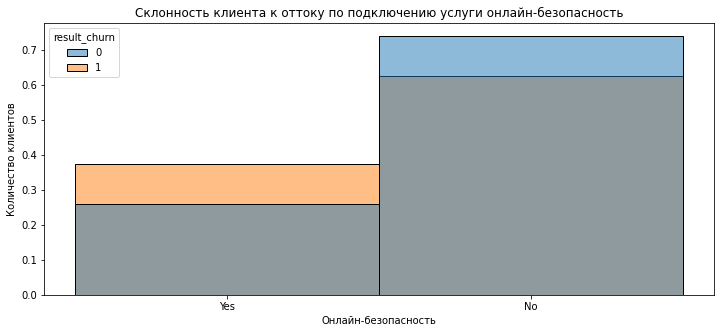

In [66]:
sns.histplot(data=telecom_final, x='online_security', hue='result_churn', stat='density', common_norm=False)
plt.xlabel('Онлайн-безопасность')
plt.ylabel('Количество клиентов')
plt.title('Склонность клиента к оттоку по подключению услуги онлайн-безопасность');

Число клиентов без подключения услуги 'онлайн-безопасность' значительно преобладает.

### Посмотрим на данные в столбце 'online_backup'

In [67]:
telecom_final['online_backup'].value_counts()

No     4211
Yes    2117
Name: online_backup, dtype: int64

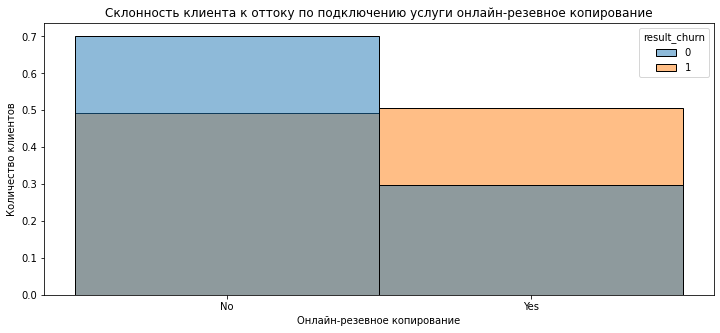

In [68]:
sns.histplot(data=telecom_final, x='online_backup', hue='result_churn', stat='density', common_norm=False)
plt.xlabel('Онлайн-резевное копирование')
plt.ylabel('Количество клиентов')
plt.title('Склонность клиента к оттоку по подключению услуги онлайн-резевное копирование');

Пользователей без услуги онлайн резервного копирования практически в 2 раза меньше.

### Посмотрим на данные в столбце 'device_protection'

In [69]:
telecom_final['device_protection'].value_counts()

No     4208
Yes    2120
Name: device_protection, dtype: int64

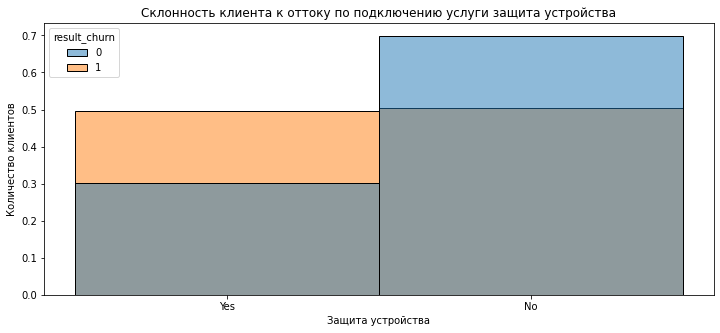

In [70]:
sns.histplot(data=telecom_final, x='device_protection', hue='result_churn', stat='density', common_norm=False)
plt.xlabel('Защита устройства')
plt.ylabel('Количество клиентов')
plt.title('Склонность клиента к оттоку по подключению услуги защита устройства');

Клиентов, которые не подключали услугу защиты устройства практически в 2 раза меньше, чем подключивших.

### Посмотрим на данные в столбце 'tech_support'

In [71]:
telecom_final['tech_support'].value_counts()

No     4553
Yes    1775
Name: tech_support, dtype: int64

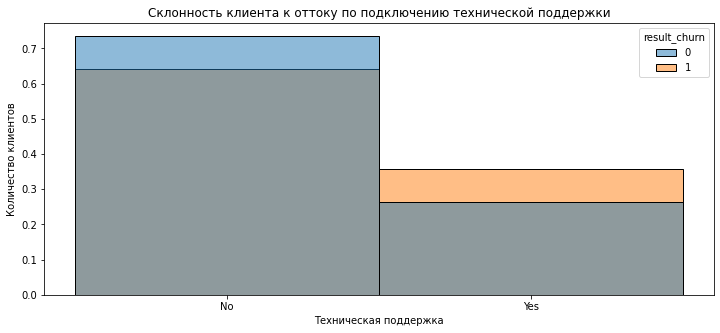

In [72]:
sns.histplot(data=telecom_final, x='tech_support', hue='result_churn', stat='density', common_norm=False)
plt.xlabel('Техническая поддержка')
plt.ylabel('Количество клиентов')
plt.title('Склонность клиента к оттоку по подключению технической поддержки');

Большинство клиентов не подключали услугу технической поддержки.

### Посмотрим на данные в столбце 'streaming_tv'

In [73]:
telecom_final['streaming_tv'].value_counts()

No     3957
Yes    2371
Name: streaming_tv, dtype: int64

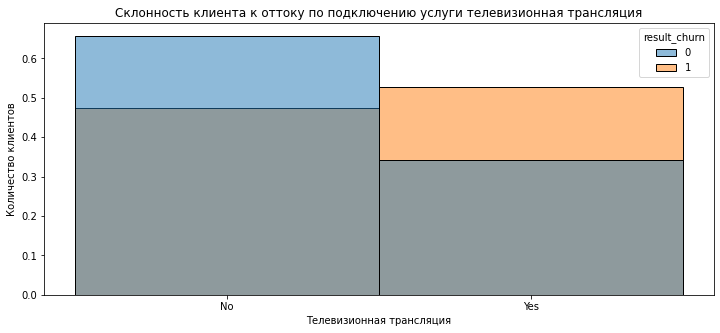

In [74]:
sns.histplot(data=telecom_final, x='streaming_tv', hue='result_churn', stat='density', common_norm=False)
plt.xlabel('Телевизионная трансляция')
plt.ylabel('Количество клиентов')
plt.title('Склонность клиента к оттоку по подключению услуги телевизионная трансляция');

Пользователей без подключения телевизионной трансляции почти в 2 раза больше, чем с подключением данной услуги.

### Посмотрим на данные в столбце 'streaming_movies'

In [75]:
telecom_final['streaming_movies'].value_counts()

No     3933
Yes    2395
Name: streaming_movies, dtype: int64

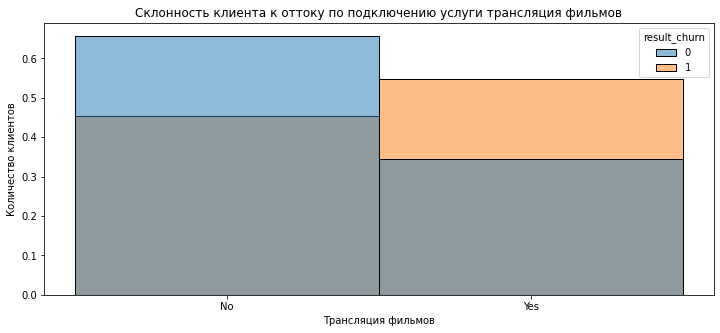

In [76]:
sns.histplot(data=telecom_final, x='streaming_movies', hue='result_churn', stat='density', common_norm=False)
plt.xlabel('Трансляция фильмов')
plt.ylabel('Количество клиентов')
plt.title('Склонность клиента к оттоку по подключению услуги трансляция фильмов');

Клиентов без подключения трансляции фильмов практически в 2 раза больше, чем с подключением данной услуги.

### Посмотрим на данные в столбце 'multiple_lines'

In [77]:
telecom_final['multiple_lines'].value_counts()

No     3694
Yes    2634
Name: multiple_lines, dtype: int64

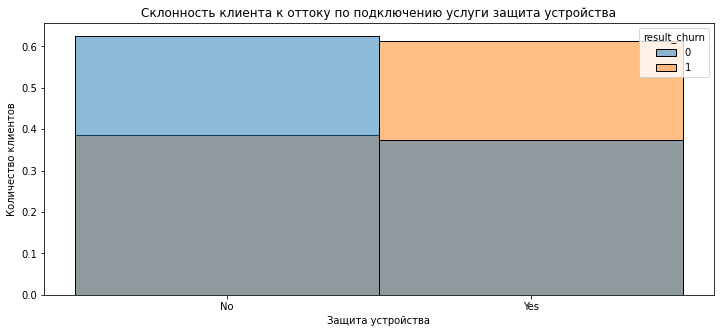

In [78]:
sns.histplot(data=telecom_final, x='multiple_lines', hue='result_churn', stat='density', common_norm=False)
plt.xlabel('Защита устройства')
plt.ylabel('Количество клиентов')
plt.title('Склонность клиента к оттоку по подключению услуги защита устройства');

Клиентов, у которых подключена 1 телефонная линия значительно больше, чем подключивших несколько линий.

Важно отметить, что клиенты с подкюченными услугами: онлайн-безопасность, онлайн резервное копирование, защита устройства, телевизионная трансляция, трансляции фильмов и есть несколько телефонных линий наиболее склонны к оттоку. Здесь можно говорить о навязывании услуг сотрудниками организации, удорожании услуг или неудовлетворенность клиентов качеством услуг.

### Посмотрим на данные в столбце 'result_churn'

In [79]:
telecom_final['result_churn'].value_counts()

0    5235
1    1093
Name: result_churn, dtype: int64

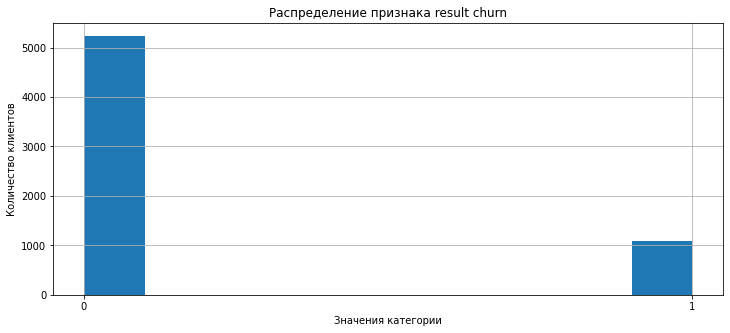

In [80]:
telecom_final['result_churn'].hist()
plt.title('Распределение признака result churn')
plt.xlabel('Значения категории')
plt.ylabel('Количество клиентов');

Наблюдается значительный дисбаланс классов, так как число действующих клиентов значительно превышает расторгнувших договора.

### Посмотрим на матрицу корреляции при помощи библиотеки 'phik'

Сначала удалим столбцы 'end_date', 'begin_date', 'customer_id' в связи с неинформативностью.

In [81]:
telecom_final = telecom_final.drop(columns=['end_date', 'begin_date', 'customer_id'])

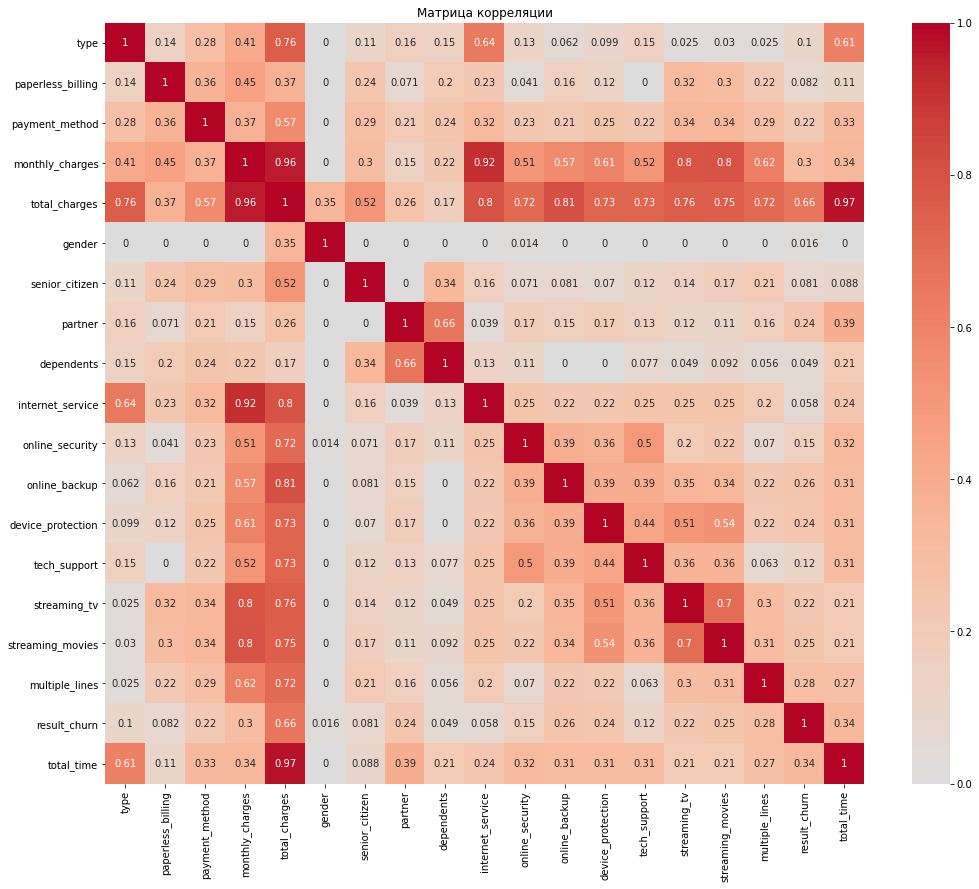

In [82]:
plt.figure(figsize=(17, 14))
sns.heatmap(telecom_final.phik_matrix(interval_cols=['monthly_charges', 'total_time']), cmap='coolwarm', center=0, annot=True)
plt.title('Матрица корреляции');

Судя по 'Матрице корреляции' нужно удалить столбцы: 'type' и 'total_charges', так как столбцы 'monthly_charges', 'type' и 'total_charges' являются взаимозависимыми. Так же можно удалить столбцы с очень низкой корреляцией, как незначительные по воздействию на целевой признак ('gender', 'partner', 'senior_citizen', 'dependents').

In [83]:
telecom_final_new = telecom_final.drop(columns=['type', 'total_charges', 'gender', 'partner', 'senior_citizen', 'dependents'])

In [84]:
telecom_final_new.columns

Index(['paperless_billing', 'payment_method', 'monthly_charges',
       'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'multiple_lines', 'result_churn', 'total_time'],
      dtype='object')

### Выведем на экран размер очищенного файла

In [85]:
telecom_final_new.shape

(6328, 13)

***Вывод***

- Объединили 4 датасета в один и посмотрели информацию о нем;
- Провели предобработку данных полученного датасета;
- Создали столбец с категориями 1(клиент останется) и 0 (клиент уйдет);
- Создали столбец для просмотра количества дней существования клиента;
- Существует три типа договоров: ежемесячный, годовой и двухлетний. Преобладает помесячный тип договора;
- Существует 4 способа оплаты услуг: электронный чек, банковский перевод (автоматический), списание с кредитной карты (автоматическое) и отправленный по почте чек. Преобладает способ - электронный чек, остальные распределены примерно одинаково;
- По клиентам распределение мужчин и женщин практически одинаковое;
- Клиентов-пенсионеров значительно меньше, чем остальных пользователей услуг;
- Женатых/замужних и свободных практически одинаковое количество;
- Без иждивенцев клиентов практически в 2 раза больше, чем с иждивенцами;
- Пользовтелей, не пользующихся интернетом значительно меньше, чем остальных;
- Большинство клиентов не подключают дополнительные услуги (например, 'online_security', 'online_backup' или  'streaming_movies');
- Удалили корреляционно зависимые признаки.

## Моделирование

### Создаем переменные для признаков и целевого признака

In [86]:
features = telecom_final_new.drop(['result_churn'], axis=1)
target = telecom_final_new['result_churn']

In [87]:
target = target.astype({'result_churn' : 'int64'})

In [88]:
target.head()

1    0
2    0
3    0
4    0
5    0
Name: result_churn, dtype: int64

### Разделим исходные данные на обучающую и тестовую выборки 1/3

In [89]:
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            stratify=target, 
                                                                            test_size=0.25, 
                                                                            random_state=80523)

### Выделяем категориальные признаки для OHE Ridge

In [90]:
ohe_features_ridge = features_train.select_dtypes(include='object').columns.to_list()
print(ohe_features_ridge)

['paperless_billing', 'payment_method', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']


### Выделяем категориальные признаки у числовых столбцов

In [91]:
num_features = features_train.select_dtypes(exclude='object').columns.to_list()
num_features

['monthly_charges', 'total_time']

### обучаем OneHotEncoder на заданных категориальных признаках тренировочной выборки

In [92]:
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

In [93]:
features_train_ridge = features_train.copy()
features_test_ridge = features_test.copy()

In [94]:
encoder_ohe.fit(features_train_ridge[ohe_features_ridge])

OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False,
              sparse_output=False)

### Добавляем закодированные признаки в features_train_ohe

При помощи encoder_ohe.get_feature_names_out() получаем названия колонок.

In [95]:
features_train_ridge[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_train_ridge[ohe_features_ridge])

### Удаляем незакодированные категориальные признаки (изначальные колонки)

In [96]:
features_train_ridge = features_train_ridge.drop(ohe_features_ridge, axis=1)

### Обучаем скелер на численных признаках тренировочной выборки и трансормируем ее

In [97]:
scaler = StandardScaler()

In [98]:
features_train_ridge[num_features] = scaler.fit_transform(features_train_ridge[num_features])

In [99]:
features_train_ridge.head()

,monthly_charges,total_time,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,internet_service_Fiber optic,internet_service_No,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,multiple_lines_Yes
3396,1.214287,0.431187,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
2626,-0.496505,1.489840,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
713,0.753556,-0.723994,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4177,-0.649503,-0.385352,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
599,-1.527501,0.912249,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Обученным энкодером кодируем тестовую выборку

In [100]:
features_test_ridge[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_test_ridge[ohe_features_ridge])

features_test_ridge = features_test_ridge.drop(ohe_features_ridge, axis=1)

### Масштабируем обученным скелером тестовую выборку

In [101]:
features_test_ridge[num_features] = scaler.transform(
    features_test_ridge[num_features])

In [102]:
features_test_ridge.head()

,monthly_charges,total_time,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,internet_service_Fiber optic,internet_service_No,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,multiple_lines_Yes
4461,1.038688,-0.002401,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
1349,-0.510414,1.057834,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
244,-0.331337,-0.773050,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2251,0.174598,-0.866414,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1947,0.901337,1.974067,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0


### Посмотрим на размеры выборок

In [103]:
features_train_ridge.shape

(4746, 15)

In [104]:
features_test_ridge.shape

(1582, 15)

In [105]:
(features_train_ridge.columns != features_test_ridge.columns).sum()

0

Получаем одинаковые признаки на обеих выборках.

### Создаем экземпляр класса RFE и обучаем модель

In [106]:
rfe = RFE(estimator=RandomForestClassifier(max_depth=5), n_features_to_select=10)
rfe.fit(features_train_ridge, target_train)

RFE(estimator=RandomForestClassifier(max_depth=5), n_features_to_select=10)

### Проводим ранжирование признаков

In [107]:
rfe.support_

array([ True,  True, False,  True, False,  True, False, False,  True,
        True,  True, False,  True,  True,  True])

In [108]:
pd.DataFrame(rfe.support_,index=features_train_ridge.columns,columns=['Rank'])

,Rank
monthly_charges,True
total_time,True
paperless_billing_Yes,False
payment_method_Credit card (automatic),True
payment_method_Electronic check,False
payment_method_Mailed check,True
internet_service_Fiber optic,False
internet_service_No,False
online_security_Yes,True
online_backup_Yes,True


In [109]:
features_train_ridge = features_train_ridge.drop(columns=['paperless_billing_Yes', 'payment_method_Electronic check',
                                                          'internet_service_Fiber optic', 'internet_service_No',
                                                          'tech_support_Yes'])
features_test_ridge = features_test_ridge.drop(columns=['paperless_billing_Yes', 'payment_method_Electronic check',
                                                          'internet_service_Fiber optic', 'internet_service_No',
                                                          'tech_support_Yes'])

In [110]:
features_train_ridge.columns

Index(['monthly_charges', 'total_time',
       'payment_method_Credit card (automatic)', 'payment_method_Mailed check',
       'online_security_Yes', 'online_backup_Yes', 'device_protection_Yes',
       'streaming_tv_Yes', 'streaming_movies_Yes', 'multiple_lines_Yes'],
      dtype='object')

In [111]:
features_train_ridge.shape

(4746, 10)

In [112]:
features_test_ridge.shape

(1582, 10)

### Смешанный лес

***Создадим матрицу гипперпараметров***

In [113]:
model_rf = RandomForestClassifier(random_state=80523)
param_rf = {}
param_rf['classifier__n_estimators'] = [5, 10, 20, 50]
param_rf['classifier__max_depth'] = [2, 5, 10]
param_rf['classifier__criterion'] = ['gini', 'entropy', 'log_loss']
param_rf['classifier'] = [model_rf]

***Обучим модель***

In [114]:
pipeline_rf = Pipeline([('classifier', model_rf)])

In [115]:
%%time
rf = GridSearchCV(pipeline_rf, param_rf, cv=3, n_jobs=-1, scoring= ['roc_auc', 'accuracy'], refit = 'roc_auc', verbose=10).fit(features_train_ridge, target_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 1/3; 1/36] START classifier=RandomForestClassifier(random_state=80523), classifier__criterion=gini, classifier__max_depth=2, classifier__n_estimators=5
[CV 1/3; 1/36] END classifier=RandomForestClassifier(random_state=80523), classifier__criterion=gini, classifier__max_depth=2, classifier__n_estimators=5; accuracy: (test=0.827) roc_auc: (test=0.719) total time=   0.0s
[CV 2/3; 1/36] START classifier=RandomForestClassifier(random_state=80523), classifier__criterion=gini, classifier__max_depth=2, classifier__n_estimators=5
[CV 2/3; 1/36] END classifier=RandomForestClassifier(random_state=80523), classifier__criterion=gini, classifier__max_depth=2, classifier__n_estimators=5; accuracy: (test=0.827) roc_auc: (test=0.686) total time=   0.0s
[CV 3/3; 1/36] START classifier=RandomForestClassifier(random_state=80523), classifier__criterion=gini, classifier__max_depth=2, classifier__n_estimators=5
[CV 3/3; 1/36] END classifier=Ra

In [116]:
print(rf.best_estimator_)
print(rf.best_score_)

Pipeline(steps=[('classifier',
                 RandomForestClassifier(criterion='entropy', max_depth=5,
                                        n_estimators=50, random_state=80523))])
0.7671533271962035


***Построим график ROC-кривой***

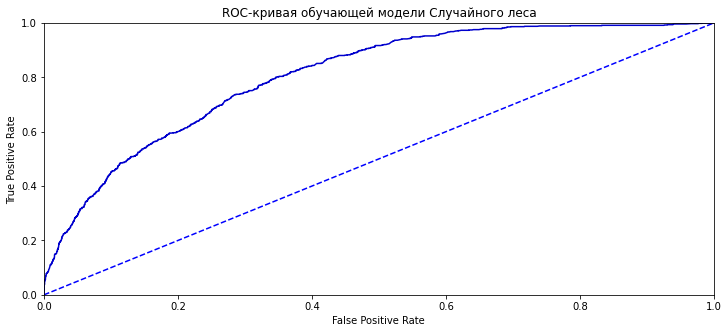

In [117]:
probabilities_rf = rf.predict_proba(features_train_ridge)
probabilities_one_rf = probabilities_rf[:, 1]

fpr, tpr, thresholds = roc_curve(target_train, probabilities_one_rf)

plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--', color='b')
plt.plot(fpr, tpr, color='mediumblue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривая обучающей модели Случайного леса')
plt.show()

### Дерево решений

***Создадим матрицу гипперпараметров***

In [118]:
model_dt = DecisionTreeClassifier(random_state=80523)
param_dt = {}
param_dt['classifier__max_depth'] = [2, 5, 10]
param_dt['classifier__min_samples_split'] = [2,5,10]
param_dt['classifier'] = [model_dt]

***Обучим модель***

In [119]:
pipeline_dt = Pipeline([('classifier', model_dt)])

In [120]:
%%time
dt = GridSearchCV(pipeline_dt, param_dt, cv=3, n_jobs=-1, scoring= ['roc_auc', 'accuracy'], refit = 'roc_auc', verbose=10).fit(features_train_ridge, target_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3; 1/9] START classifier=DecisionTreeClassifier(random_state=80523), classifier__max_depth=2, classifier__min_samples_split=2
[CV 1/3; 1/9] END classifier=DecisionTreeClassifier(random_state=80523), classifier__max_depth=2, classifier__min_samples_split=2; accuracy: (test=0.827) roc_auc: (test=0.664) total time=   0.0s
[CV 2/3; 1/9] START classifier=DecisionTreeClassifier(random_state=80523), classifier__max_depth=2, classifier__min_samples_split=2
[CV 2/3; 1/9] END classifier=DecisionTreeClassifier(random_state=80523), classifier__max_depth=2, classifier__min_samples_split=2; accuracy: (test=0.827) roc_auc: (test=0.627) total time=   0.0s
[CV 3/3; 1/9] START classifier=DecisionTreeClassifier(random_state=80523), classifier__max_depth=2, classifier__min_samples_split=2
[CV 3/3; 1/9] END classifier=DecisionTreeClassifier(random_state=80523), classifier__max_depth=2, classifier__min_samples_split=2; accuracy: (test=0.827) 

In [121]:
print(dt.best_estimator_)
print(dt.best_score_)

Pipeline(steps=[('classifier',
                 DecisionTreeClassifier(max_depth=5, min_samples_split=10,
                                        random_state=80523))])
0.7393564157487834


***Построим график ROC-кривой***

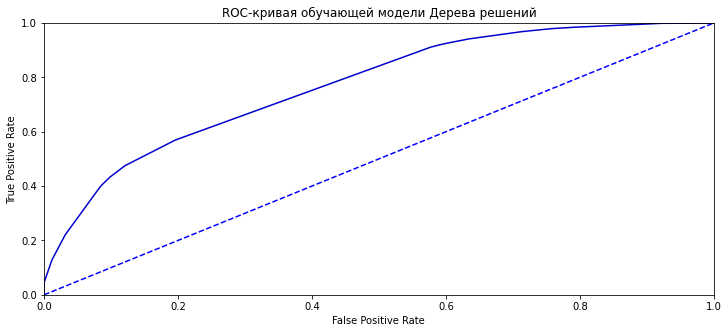

In [122]:
probabilities_dt = dt.predict_proba(features_train_ridge)
probabilities_one_dt = probabilities_dt[:, 1]

fpr, tpr, thresholds = roc_curve(target_train, probabilities_one_dt)

plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--', color='b')
plt.plot(fpr, tpr, color='mediumblue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривая обучающей модели Дерева решений')
plt.show()

### Метод K-ближайших соседей

***Создадим матрицу гипперпараметров***

In [123]:
model_kn = KNeighborsClassifier()
param_kn = {}
param_kn['classifier__n_neighbors'] = [2,5,10,25,50]
param_kn['classifier'] = [model_kn]

***Обучим модель***

In [124]:
pipeline_kn = Pipeline([('classifier', model_kn)])

In [125]:
%%time
kn = GridSearchCV(pipeline_kn, param_kn, cv=3, n_jobs=-1, scoring= ['roc_auc', 'accuracy'], refit = 'roc_auc', verbose=10).fit(features_train_ridge, target_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3; 1/5] START classifier=KNeighborsClassifier(), classifier__n_neighbors=2
[CV 1/3; 1/5] END classifier=KNeighborsClassifier(), classifier__n_neighbors=2; accuracy: (test=0.818) roc_auc: (test=0.601) total time=   0.1s
[CV 2/3; 1/5] START classifier=KNeighborsClassifier(), classifier__n_neighbors=2
[CV 2/3; 1/5] END classifier=KNeighborsClassifier(), classifier__n_neighbors=2; accuracy: (test=0.819) roc_auc: (test=0.617) total time=   0.1s
[CV 3/3; 1/5] START classifier=KNeighborsClassifier(), classifier__n_neighbors=2
[CV 3/3; 1/5] END classifier=KNeighborsClassifier(), classifier__n_neighbors=2; accuracy: (test=0.822) roc_auc: (test=0.639) total time=   0.1s
[CV 1/3; 2/5] START classifier=KNeighborsClassifier(), classifier__n_neighbors=5
[CV 1/3; 2/5] END classifier=KNeighborsClassifier(), classifier__n_neighbors=5; accuracy: (test=0.815) roc_auc: (test=0.679) total time=   0.1s
[CV 2/3; 2/5] START classifier=KNeighbor

In [126]:
print(kn.best_estimator_)
print(kn.best_score_)

Pipeline(steps=[('classifier', KNeighborsClassifier(n_neighbors=50))])
0.7523001180461435


***Построим график ROC-кривой***

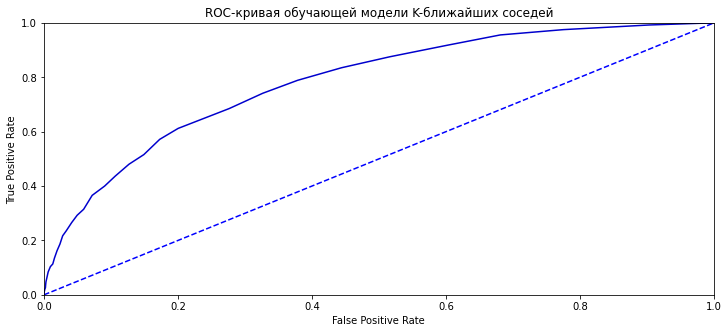

In [127]:
probabilities_kn = kn.predict_proba(features_train_ridge)
probabilities_one_kn = probabilities_kn[:, 1]

fpr, tpr, thresholds = roc_curve(target_train, probabilities_one_kn)

plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--', color='b')
plt.plot(fpr, tpr, color='mediumblue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривая обучающей модели K-ближайших соседей')
plt.show()

### Градиентный бустинг с CATBOOST

***Создадим матрицу гипперпараметров***

In [128]:
model_cat = CatBoostClassifier(random_state=80523, silent=True, loss_function = 'CrossEntropy')
param_cat = {}
param_cat['classifier__iterations'] = [100, 250, 500, 800]
param_cat['classifier__max_depth'] = [2, 4, 5, 6, 7, 8, 9, 10]
param_cat['classifier__learning_rate'] = [0.01, 0.2, 0.5]
param_cat['classifier__l2_leaf_reg'] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
param_cat['classifier'] = [model_cat]

***Обучим модель***

In [129]:
pipeline_cat = Pipeline([('classifier', model_cat)])

In [130]:
rs = RandomizedSearchCV(pipeline_cat, param_cat, cv=3, n_jobs=-1, scoring= ['roc_auc', 'accuracy'], refit = 'roc_auc', verbose=10).fit(features_train_ridge, target_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3; 1/10] START classifier=<catboost.core.CatBoostClassifier object at 0x7f86ed5b8ee0>, classifier__iterations=800, classifier__l2_leaf_reg=1, classifier__learning_rate=0.01, classifier__max_depth=2
[CV 1/3; 1/10] END classifier=<catboost.core.CatBoostClassifier object at 0x7f86ed5b8ee0>, classifier__iterations=800, classifier__l2_leaf_reg=1, classifier__learning_rate=0.01, classifier__max_depth=2; accuracy: (test=0.831) roc_auc: (test=0.797) total time=   1.7s
[CV 2/3; 1/10] START classifier=<catboost.core.CatBoostClassifier object at 0x7f86ed5b8ee0>, classifier__iterations=800, classifier__l2_leaf_reg=1, classifier__learning_rate=0.01, classifier__max_depth=2
[CV 2/3; 1/10] END classifier=<catboost.core.CatBoostClassifier object at 0x7f86ed5b8ee0>, classifier__iterations=800, classifier__l2_leaf_reg=1, classifier__learning_rate=0.01, classifier__max_depth=2; accuracy: (test=0.839) roc_auc: (test=0.771) total time=   1.

In [131]:
print(rs.best_estimator_)
print(rs.best_score_)

Pipeline(steps=[('classifier',
                 <catboost.core.CatBoostClassifier object at 0x7f86e516b610>)])
0.8890510983564789


In [132]:
rs_roc = pd.DataFrame(rs.cv_results_).sort_values('mean_test_roc_auc', ascending=False).iloc[0, :]['mean_test_roc_auc']
rs_acc = pd.DataFrame(rs.cv_results_).sort_values('mean_test_roc_auc', ascending=False).iloc[0, :]['mean_test_accuracy']

rf_roc = pd.DataFrame(rf.cv_results_).sort_values('mean_test_roc_auc', ascending=False).iloc[0, :]['mean_test_roc_auc']
rf_acc = pd.DataFrame(rf.cv_results_).sort_values('mean_test_roc_auc', ascending=False).iloc[0, :]['mean_test_accuracy']

dt_roc = pd.DataFrame(dt.cv_results_).sort_values('mean_test_roc_auc', ascending=False).iloc[0, :]['mean_test_roc_auc']
dt_acc = pd.DataFrame(dt.cv_results_).sort_values('mean_test_roc_auc', ascending=False).iloc[0, :]['mean_test_accuracy']

kn_roc = pd.DataFrame(kn.cv_results_).sort_values('mean_test_roc_auc', ascending=False).iloc[0, :]['mean_test_roc_auc']
kn_acc = pd.DataFrame(kn.cv_results_).sort_values('mean_test_roc_auc', ascending=False).iloc[0, :]['mean_test_accuracy']

In [133]:
pd.DataFrame({'AUC': [rf_roc, dt_roc, kn_roc, rs_roc], 
              'Accuracy': [rf_acc, dt_acc, kn_acc, rs_acc],
              }, 
             index=['Смешанный лес', 'Дерево решений', 'K-метод ближайших соседей', 'Градиентный бестинг'])

,AUC,Accuracy
Смешанный лес,0.767153,0.829541
Дерево решений,0.739356,0.828276
K-метод ближайших соседей,0.752300,0.830173
Градиентный бестинг,0.889051,0.907290


***Вывод***

- Закодировали данные для обучения;
- Провели масштабирование признаков;
- Удалили новые корреляционные зависимости методом RFE;
- Обучение проводили на четырех моделях Смешанный лес, Дерево решений, метод K-ближайших соседей, Градиентный бустинг с CATBOOST.


Модели Смешанный лес, Дерево решений и K-метод ближайших соседей показали себя практически одинаково. Но Градиентный бустинг был лучше по всем параметрам AUC-ROC = 0.8980, Accuracy = 0.9119. Это показывает, что модель достаточно хорошо обучилась в выборе оттока клиентов. Тестирование будем проводить на модели Градиентный бустинг.

## Тестирование модели

***Тестирование модели на Градиентном бустинге***

In [134]:
%%time

predict_rs_test = rs.predict(features_test_ridge)

auc_roc_rs = roc_auc_score(target_test, rs.predict_proba(features_test_ridge)[:, 1])
accuracy_rs = accuracy_score(target_test, predict_rs_test)

print('Accuracy : ', accuracy_rs)
print('ROC-AUC : ', auc_roc_rs)

Accuracy :  0.9184576485461441
ROC-AUC :  0.906930604409596
CPU times: user 9.75 ms, sys: 63 µs, total: 9.82 ms
Wall time: 9.09 ms


***ROC - кривая***

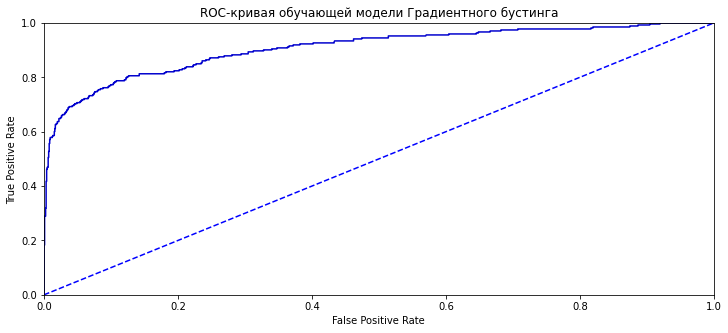

In [135]:
probabilities_rs = rs.predict_proba(features_test_ridge)
probabilities_one_rs = probabilities_rs[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_rs)

plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--', color='b')
plt.plot(fpr, tpr, color='mediumblue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривая обучающей модели Градиентного бустинга')
plt.show()

### Анализ важности признаков

In [136]:
importances = rs.best_estimator_._final_estimator.feature_importances_
feature_list = list(features_test_ridge.columns)
feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})
feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)

feature_results.head(10)

,feature,importance
0,total_time,62.934612
1,monthly_charges,21.149984
2,multiple_lines_Yes,2.799645
3,device_protection_Yes,2.598353
4,online_backup_Yes,2.189020
5,payment_method_Mailed check,2.161439
6,payment_method_Credit card (automatic),2.144374
7,online_security_Yes,1.934012
8,streaming_movies_Yes,1.285894
9,streaming_tv_Yes,0.802666


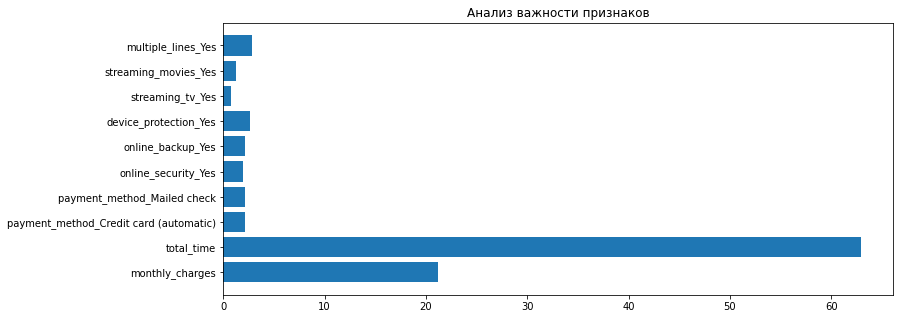

In [137]:
feature_import = importances
col_names = features_test_ridge.columns
indices = np.argsort(feature_import)[::-1]
plt.title('Анализ важности признаков')
plt.barh(col_names,feature_import);

***Матрица ошибок***

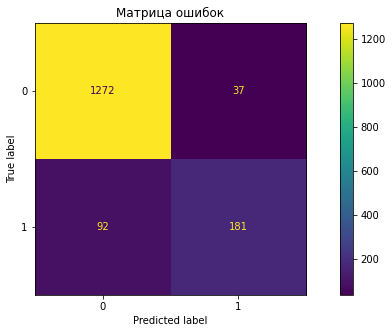

In [138]:
ConfusionMatrixDisplay.from_estimator(rs, features_test_ridge, target_test)
plt.title('Матрица ошибок')
plt.show()

***Вывод***

- Тестирование модели проводили на Градиентный бустинг с CATBOOST;
- При лучших параметрах: {'max_depth': 4, 'learning_rate': 0.2, 'l2_leaf_reg': 1, 'iterations': 250} были достигнуты Accuracy :  0.9355246523388117 и ROC-AUC :  0.9234560957250033;
- Анализ важности признаков показал, что наиболее важными признаками являются: период времени, в течение которого человек является клиентом и сумма ежемесячного платежа. Остальные признаки являются очень слабо важными;
- Матрица ошибок показала, что верноположительных прогнозов 1298, верноотрицательных прогнозов 182, ложноположительных прогнозов 11, ложноотрицательных прогнозов 91.

## Отчет о проделанной работе

1. Целью исследования являлось создание модели, которая на основании имеющихся даннных будет предсказывать уход клиента от компании. Целевой метрикой оценки точности предсказания модели считается AUC-ROC. Дополнительной метрикой - Accuracy.

2. Исходные данные состояли из 4 таблиц с информацией о договоре, персональных данных клиента, интернет-услугах и услугах телефонии.

Все были объединены в один датасет. Были пропуски в столбцах с услугами, ввиду того, что клиенты ими не пользовались. Добавили столбец с количеством дней от регистрации договора даты выгрузки. Можно отметить следующее:
- существует три типа договоров: ежемесячный, годовой и двухлетний. Преобладает помесячный тип договора;
- существует 4 способа оплаты услуг: электронный чек, банковский перевод (автоматический), списание с кредитной карты (автоматическое) и отправленный по почте чек. Преобладает способ - электронный чек, остальные распределены примерно одинаково;
- по клиентам распределение мужчин и женщин практически одинаковое;
- клиентов-пенсионеров значительно меньше, чем остальных пользователей услуг;
- женатых/замужних и свободных практически одинаковое количество;
- без иждивенцев клиентов практически в 2 раза больше, чем с иждивенцами;
- пользователей, не пользующихся интернетом значительно меньше, чем остальных;
- большинство клиентов не подключают дополнительные услуги.

Создали целевой признак 'result_churn' с обозначением '0' - действующий клиент, '1' - клиент, прекративший сотрудничество. Удалили сильно корреляционно зависимые признаки и неинформативные столбцы ('end_date', 'begin_date', 'type', 'customer_id', 'total_charges', 'gender', 'partner', 'senior_citizen', 'dependents').

3. Разделили данные обучающую и тестовую выборки в пропорции 1/3. Провели кодирование признаков методом OHE. Провели масштабирование признаков при помощи StandardScaler. Удалили очень слабые корреляционные зависимости методом RFE.
Обучение проводили на четырех моделях: Смешанный лес, Дерево решений, метод K-ближайших соседей, Градиентный бустинг с CATBOOST. Для каждой модели построили ROC-кривую. Признаки, которые использовали при обучении моделей: 'monthly_charges', 'total_time', 'payment_method_Credit card (automatic)', 'payment_method_Mailed check', 'online_security_Yes', 'online_backup_Yes', 'device_protection_Yes', 'streaming_tv_Yes', 'streaming_movies_Yes', 'multiple_lines_Yes'.

***Смешанный лес:*** AUC-ROC = 0.767153 Accuracy = 0.829541

***Дерево решений:*** AUC-ROC = 0.739356 Accuracy = 0.828276 

***K-метод ближайших соседей:*** AUC-ROC = 0.752300 Accuracy = 0.830173

***Градиентный бустинг с CATBOOST:*** AUC-ROC = 0.903740 Accuracy = 0.919090

Модели Смешанный лес, Дерево решений и K-метод ближайших соседей показали себя практически одинаково. Но Градиентный бустинг был лучше по всем параметрам AUC-ROC = 0.9037, Accuracy = 0.9190. Это показывает, что модель достаточно хорошо обучилась в выборе оттока клиентов.

4. Тестирование модели проводили на Градиентный бустинг с CATBOOST.
- При лучших параметрах: {'max_depth': 4, 'learning_rate': 0.2, 'l2_leaf_reg': 1, 'iterations': 250} были достигнуты Accuracy :  0.9355 и ROC-AUC :  0.9235;
- Анализ важности признаков показал, что наиболее важными признаками являются: период времени, в течение которого человек является клиентом и сумма ежемесячного платежа. Остальные признаки ('multiple_lines_Yes',  'device_protection_Yes', 'online_backup_Yes', 'online_security_Yes', 'payment_method_Mailed check', 'streaming_movies_Yes', 'payment_method_Credit card (automatic)', 'streaming_tv_Yes') являются очень слабо важными;
- Матрица ошибок показала, что верноположительных прогнозов 1298, верноотрицательных прогнозов 182, ложноположительных прогнозов 11, ложноотрицательных прогнозов 91.

Можно сделать вывод, о том что модель Градиентный бустинг с CATBOOST хорошо обучилась и показала отличные результаты при тестировании. Это значит, что данную модель можно рекомендовать для работы.

Также можно отметить:
- В данных для проекта не было информации о сегментации клиентов, что бы компания могла адресно с ними взаимодействовать. Это позволило бы повысить эффективность управления оттоком;
- Количество предоставленных данных о клиентах недостаточно для построения более точной модели и важно продолжать расширять клиентскую базу.

Все шаги плана были учтены. Но в ходе исследовательского анализа данных было принято решение о создании столбца 'total_time'. Он нам нужен для видимости длительности периода существования клиента. Этот признак и оказался самым важным для обучения моделей. 

Подведем итоги проделанной работы. Основная цель проекта - создание модели, которая на основании имеющихся данных будет предсказывать уход клиента от компании достигнута. Целевая метрика оценки точности предсказания модели AUC-ROC рассчитана, дополнительная метрика Accuracy рассчитана. Наша модель готова к работе, но при расширении клиентской базы ее нужно будет дорабатывать и улучшать. Я считаю, что основной проблемой проекта был переизбыток данных, которые практически не влияют на отток клиента из компании. Был проделан огромный анализ для выявления и удаления ряда признаков. Но я открыла для себя метод RFE для удаления слабых корреляционных зависимостей. На мой взгляд, не хватает информации о сегментации клиентов, а это могло бы повысить эффективность управления оттоком клиентов. В целом, вся работа над проектом была интересной и познавательной.